Please upload 'aquatic_dataset.zip'


Saving aquatic_dataset.zip to aquatic_dataset.zip
Dataset extracted successfully!
Loaded 621 training images and 185 testing images.
Categories: ['Fish', 'Goldfish', 'Harbor seal', 'Jellyfish', 'Lobster', 'Oyster', 'Sea turtle', 'Squid', 'Starfish']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 577ms/step - accuracy: 0.2613 - loss: 2.2627 - val_accuracy: 0.6324 - val_loss: 1.1695
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 524ms/step - accuracy: 0.7450 - loss: 0.8576 - val_accuracy: 0.7514 - val_loss: 0.8446
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 551ms/step - accuracy: 0.8199 - loss: 0.5461 - val_accuracy: 0.7514 - val_loss: 0.8253
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 616ms/step - accuracy: 0.9035 - loss: 0.3238 - val_accuracy: 0.6919 - val_loss: 0.9143
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 527ms/step - accuracy: 0.9371 - loss: 0.2739 - val_accuracy: 0.7351 - val_loss: 0.8513
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - a

Saving img.jpg to img.jpg
Uploaded file: img.jpg


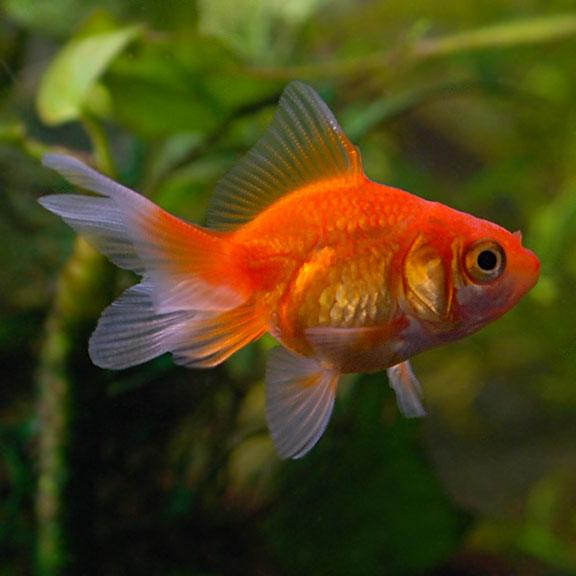

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted category: Goldfish


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, Image

# Step 1: Upload the dataset
print("Please upload 'aquatic_dataset.zip'")
uploaded = files.upload()

# Define dataset ZIP file path
zip_path = "aquatic_dataset.zip"
extract_path = "aquatic_dataset"

# Step 2: Extract dataset
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")
else:
    raise FileNotFoundError("Dataset ZIP file not found! Please upload 'aquatic_dataset.zip'.")

# Step 3: Define dataset paths
dataset_path = os.path.join(extract_path, "images")
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

# Verify dataset structure
if not os.path.exists(train_path) or not os.path.exists(test_path):
    print("Error: Train/Test directories not found.")
    raise FileNotFoundError("Ensure that the dataset contains 'images/train' and 'images/test'.")

# Step 4: Function to load images
def load_images(data_dir, img_size=(128, 128)):
    categories = sorted(os.listdir(data_dir))
    images, labels = [], []

    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping...")
                continue

            img = cv2.resize(img, img_size) / 255.0  # Normalize
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels), categories

# Load datasets
X_train, y_train, categories = load_images(train_path)
X_test, y_test, _ = load_images(test_path)

print(f"Loaded {len(X_train)} training images and {len(X_test)} testing images.")
print(f"Categories: {categories}")

# Step 5: Load MobileNetV2 pre-trained model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')#removes default classification
base_model.trainable = False  # Freeze the base model layers

# Step 6: Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),#reduces overfitting
    layers.Dense(128, activation='relu'),#it reduces vanishing gradient
    layers.Dropout(0.2),#prevent overfitting
    layers.Dense(len(categories), activation='softmax')#for multiclass classification,convert raw output into probabilities
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Step 8: Save the trained model
model.save("aquatic_model_transfer_learning.keras")
print("Model saved as 'aquatic_model_transfer_learning.keras'.")

# Step 9: Function to predict an uploaded image
def predict_image(image_path):
    if not os.path.isfile(image_path):
        print("Error: Image file not found!")
        return None

    img = cv2.imread(image_path)
    if img is None:
        print("Error: Unable to read image. Check file format.")
        return None

    img = cv2.resize(img, (128, 128)) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)#to get class probabilities
    category = categories[np.argmax(prediction)]
    return category#with highest probability

# Step 10: Upload an image for testing
print("Upload an image to test the model:")
uploaded = files.upload()

for filename in uploaded.keys():
    print("Uploaded file:", filename)
    display(Image(filename=filename))
    predicted_category = predict_image(filename)
    if predicted_category:
        print(f"Predicted category: {predicted_category}")
